导入库

In [1]:
%matplotlib widget

In [2]:
import os
import numpy as np
import json

# import utils
from DataPrepare import EEGAudioDataset
from torch_dct import dct

公共变量

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# words_path = r'./feat/words'
words_path = r'./feat'
pts = ['sub-%02d'%i for i in range(1,11)]
pt = 'sub-06'
test_word = 10
config_path = r'./config'
model_name = 'test'

读取数据

In [4]:
folder_path = os.path.join(words_path,f'{pt}')
filename = os.listdir(folder_path)[test_word]
word_info = np.load(os.path.join(folder_path,filename),allow_pickle=True)
word=word_info.item()['label']
eeg=word_info.item()['eeg']
audio=word_info.item()['audio']

print(word,eeg.shape,audio.shape)

verstijfde (3075, 127) (48062,)


数据预处理

In [5]:
with open(os.path.join(config_path,f'{model_name}.json'),'r') as f:
    cfg = json.load(f)
    model_cfg = cfg['model_config']
    data_cfg = cfg['data_config']

# load config 
seg_size = model_cfg['seg_size']
pred_size = model_cfg['pred_size']
batch_size = model_cfg['batch_size']
lr = model_cfg['lr']
b1 = model_cfg['b1']
b2 = model_cfg['b2']
d_model = model_cfg['d_model']
embedding_dim = model_cfg['embedding_dim']
nhead = model_cfg['nhead']
n_layer = model_cfg['n_layer']
n_embedding = model_cfg['n_embedding']

data_path = data_cfg['data_path']
win_len = data_cfg['win_len']
frame_shift = data_cfg['frame_shift']
eeg_sr = data_cfg['eeg_sr']
audio_sr = data_cfg['audio_sr']
n_mels = data_cfg['n_mels']
pad_mode = data_cfg['pad_mode']

提取高频eeg信号和音频信号的梅尔频谱

In [6]:
dataset = EEGAudioDataset(pt,data_path,win_len,frame_shift,eeg_sr,audio_sr,n_mels,pad_mode)
train_encoder_data,train_decoder_input_data,train_decoder_output_data,test_encoder_data,test_decoder_input_data,test_decoder_output_data = dataset.prepareData(seg_size)

In [7]:
print(train_encoder_data.shape,train_decoder_input_data.shape,train_decoder_output_data.shape,test_encoder_data.shape,test_decoder_input_data.shape,test_decoder_output_data.shape)

(25200, 204, 127) (25200, 11, 80) (25200, 11, 80) (2800, 204, 127) (2800, 11, 80) (2800, 11, 80)


In [ ]:
from transformer import torchTransformer
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
tensor_type = torch.cuda.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = torchTransformer(d_model,embedding_dim,nhead,n_layer,n_embedding,seg_size,pred_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
criterion = nn.MSELoss()


In [ ]:
eeg = EEGAudioDataset.extractHG(eeg,eeg_sr,windowLength=win_len,frameshift=frame_shift)
melspec = EEGAudioDataset.extractMelSpecs(audio,audio_sr,windowLength=win_len,frameshift=frame_shift,n_mels=n_mels)
# print(eeg.shape,melspec.shape)
if melspec.shape[0]!=eeg.shape[0]:
    minlen = min(melspec.shape[0],eeg.shape[0])
    melspec = melspec[:minlen,:]
    eeg = eeg[:minlen,:]
print(eeg.shape,melspec.shape)

TypeError: EEGAudioDataset.extractHG() missing 1 required positional argument: 'sr'

预处理

In [ ]:
eeg_mean = np.mean(eeg)
eeg_std = np.std(eeg)
eeg = (eeg-eeg_mean)/eeg_std
eeg_list = []
mel_list = []
hop_size = 1
pad_width = ((int(np.floor((seg_size-hop_size)/2.0)),int(np.ceil((seg_size-hop_size)/2.0))),(0,0))
pad_eeg = np.pad(eeg,pad_width,mode=pad_mode)
pad_mel = np.pad(melspec,pad_width,mode=pad_mode)
num_win = int(len(eeg)/float(hop_size))
for i in range(num_win):
    start = i*hop_size
    end = start + seg_size
    eeg_list.append(pad_eeg[start:end,:])
    mel_list.append(pad_mel[start:end,:])

eeg_data = np.stack(eeg_list,axis=0)
mel_data = np.stack(mel_list,axis=0)
print(eeg_data.shape,mel_data.shape)

(150, 16, 127) (150, 16, 40)


加载模型

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from itertools import chain
from model.VQVAE import  MelEncoder,EEGEncoder,VectorQuantizer,MelLinearDecoder,LinearClassifier

In [ ]:
from model.models import Model

In [ ]:
input_dim = eeg_data.shape[-1]
output_dim = mel_data.shape[-1]

tensor_type = torch.cuda.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eeg_encoder = EEGEncoder(input_dim=input_dim,d_model=d_model,n_layer=n_layer).to(device)
mel_encoder = MelEncoder(input_dim=output_dim,d_model=d_model).to(device)
vector_quantizer = VectorQuantizer(num_embeddings=n_embedding,embedding_dim=embedding_dim).to(device)
mel_decoder = MelLinearDecoder(output_dim=output_dim,d_model=d_model,seg_size=seg_size).to(device)
classifier = LinearClassifier(num_embedding=n_embedding,embedding_dim=embedding_dim).to(device)

# eeg_optimizer = torch.optim.Adam(chain(eeg_encoder.parameters(),classifier.parameters()),lr=lr,betas=(b1,b2))
# scheduler = MultiStepLR(main_optimizer,milestones=[10,20,30],gamma=0.5)

l1loss = nn.SmoothL1Loss().double().to(device)
loss_fn = lambda x,y:(l1loss(x.double(), y.double())+l1loss(torch.exp(x.double()).double(),torch.exp(y.double()).double())+l1loss(dct(x.double(),norm='ortho').double(),dct(y.double(),norm='ortho').double()))

checkpoint = utils.scan_checkpoint(f'./res/{pt}/{model_name}',f'{model_name}')
state_dict = utils.load_checkpoint(checkpoint)
eeg_encoder.load_state_dict(state_dict['eeg_encoder'])
mel_encoder.load_state_dict(state_dict['mel_encoder'])
vector_quantizer.load_state_dict(state_dict['vector_quantizer'])
mel_decoder.load_state_dict(state_dict['mel_decoder'])
classifier.load_state_dict(state_dict['classifier'])

# eeg_encoder.eval()
# mel_encoder.eval()
# vector_quantizer.eval()
# mel_decoder.eval()
# classifier.eval()

Loading './res/sub-06/vqvae_cls_n512d1024/vqvae_cls_n512d1024_001000.pt'
Complete.


<All keys matched successfully>

In [ ]:
eeg_encoder.eval()

EEGEncoder(
  (TransformerEncoder): RoPETransformerEncoder(
    (aff_input): Linear(in_features=127, out_features=128, bias=True)
    (RoPEMultiHeadAttention): RotaryPEMultiHeadAttention(
      (query): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (key): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (value): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (softmax): Softmax(dim=2)
      (output): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (query_rotary_pe): RotaryPositionalEmbeddings()
      (key_rotary_pe): RotaryPositionalEmbeddings()
    )
    (ff): FeedForward(
      (layer1): Linear(in_features=128, out_features=512, bias=True)
      (layer2): Linear(in_features=512, out_features=128, bias=True)
      (dropout): Drop

In [ ]:
mel_encoder.eval()

MelEncoder(
  (TransformerEncoder): RoPETransformerEncoder(
    (aff_input): Linear(in_features=40, out_features=128, bias=True)
    (RoPEMultiHeadAttention): RotaryPEMultiHeadAttention(
      (query): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (key): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (value): PrepareForMultiHeadAttention(
        (linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (softmax): Softmax(dim=2)
      (output): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (query_rotary_pe): RotaryPositionalEmbeddings()
      (key_rotary_pe): RotaryPositionalEmbeddings()
    )
    (ff): FeedForward(
      (layer1): Linear(in_features=128, out_features=512, bias=True)
      (layer2): Linear(in_features=512, out_features=128, bias=True)
      (dropout): Dropo

In [ ]:
vector_quantizer.eval()

VectorQuantizer()

In [ ]:
mel_decoder.eval()

MelLinearDecoder(
  (decoder): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2048, out_features=640, bias=True)
  )
)

In [ ]:
classifier.eval()

LinearClassifier(
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
  )
)

In [ ]:
eeg_data =torch.from_numpy(eeg_data).to(device).type(tensor_type)
mel_data = torch.from_numpy(mel_data).to(device).type(tensor_type)

In [ ]:
encoded_eeg = eeg_encoder(eeg_data)
encoded_mel = mel_encoder(mel_data)
eeg_vq = classifier.cls(encoded_eeg)
_,mel_vq = vector_quantizer(encoded_mel)
eeg_out = mel_decoder(eeg_vq)
mel_out = mel_decoder(mel_vq)
pcc = utils.calPCC(eeg_out,mel_data)
eeg_out = eeg_out.detach().cpu().numpy()
mel_out = mel_out.detach().cpu().numpy()
mel_data = mel_data.detach().cpu().numpy()

In [ ]:
print(pcc)

0.7295536329791068


In [ ]:
import librosa.display
import matplotlib.pyplot as plt
def nolabel():
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])

    plt.xlabel('')
    plt.ylabel('')

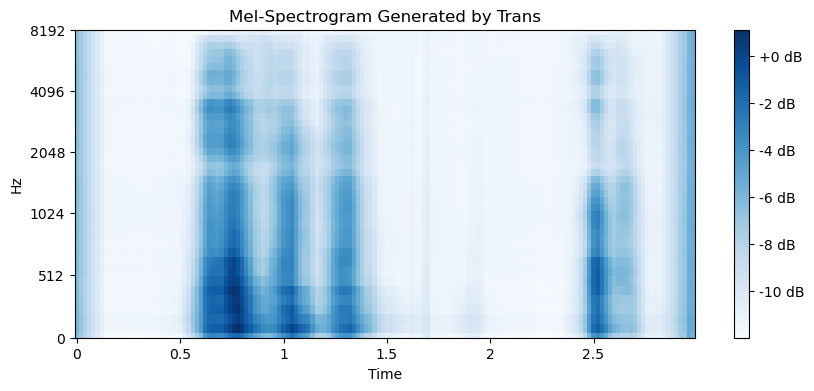

In [ ]:
# utils.plot_spectrogram(eeg_out[:-4],audio_sr,int(audio_sr*frame_shift),int(audio_sr*win_len))
plt.figure(figsize=(10,4))
librosa.display.specshow(utils.getFlatMel(eeg_out).T,sr=audio_sr,hop_length=int(audio_sr*frame_shift),n_fft=int(audio_sr*win_len),x_axis='time',y_axis='mel',cmap='Blues')
plt.ylim(0,8192)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Generated by Trans')
# nolabel()
np.save(os.path.join('test_mel_files',f'{pt}_{test_word}_{word}_eeg_trans.npy'),utils.getFlatMel(eeg_out).T)

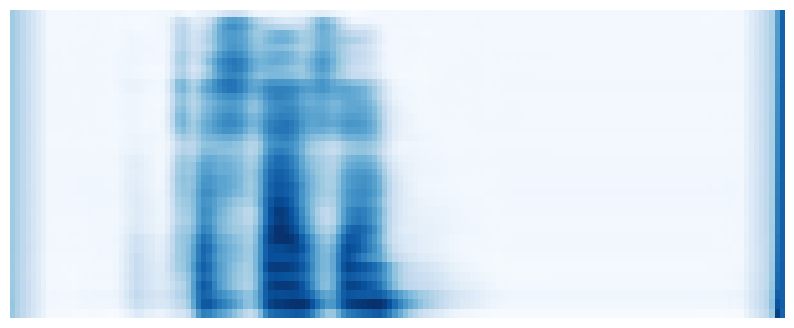

In [ ]:
# utils.plot_spectrogram(mel_out[:-4],audio_sr,int(audio_sr*frame_shift),int(audio_sr*win_len))
plt.figure(figsize=(10,4))
librosa.display.specshow(utils.getFlatMel(mel_out).T,sr=audio_sr,hop_length=int(audio_sr*frame_shift),n_fft=int(audio_sr*win_len),x_axis='time',y_axis='mel',cmap='Blues')
# plt.ylim(0,8192)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram Generated by Pretrained VQVAE')
nolabel()

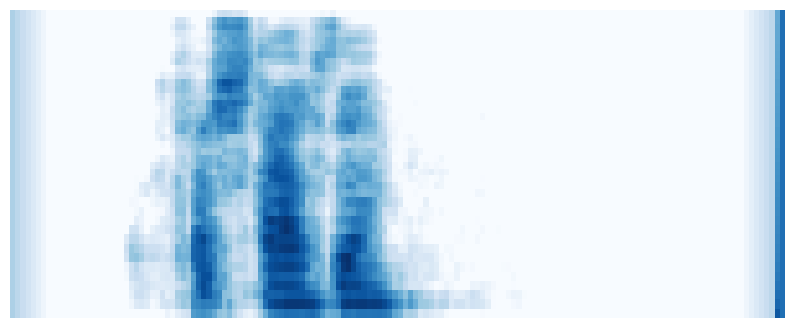

In [ ]:
# utils.plot_spectrogram(mel_data[:-4],audio_sr,int(audio_sr*frame_shift),int(audio_sr*win_len))
plt.figure(figsize=(10,4))
librosa.display.specshow(utils.getFlatMel(mel_data).T,sr=audio_sr,hop_length=int(audio_sr*frame_shift),n_fft=int(audio_sr*win_len),x_axis='time',y_axis='mel',cmap='Blues')
# plt.ylim(0,8192)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel-Spectrogram of Original Audio')
nolabel()

In [ ]:

np.save(os.path.join('test_mel_files',f'{pt}_{test_word}_{word}_mel.npy'),utils.getFlatMel(mel_out).T)
np.save(os.path.join('test_mel_files',f'{pt}_{test_word}_{word}_origin.npy'),utils.getFlatMel(mel_data).T)


(48062,)


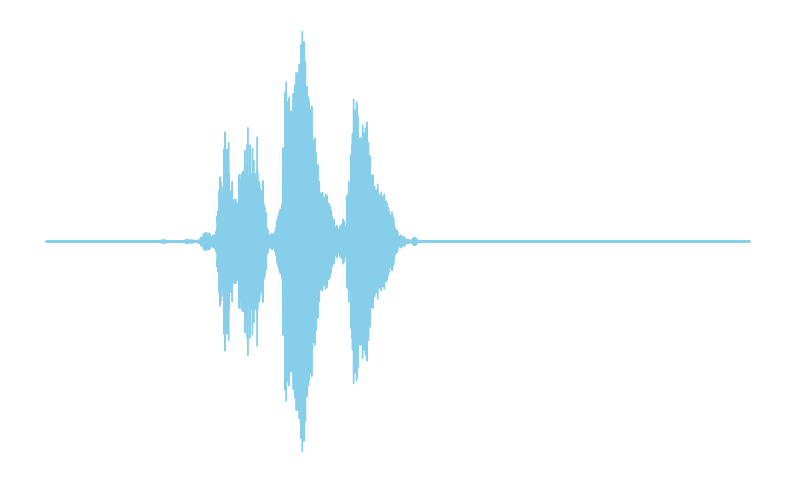

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

print(audio.shape)
plt.figure(figsize=(10, 6))
librosa.display.waveshow(np.float32(audio), sr=audio_sr,color='skyblue')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

plt.xlabel('')
plt.ylabel('')


# plt.title('Waveform')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
plt.show()